In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import ndcg
import MAP
from functools import reduce

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
df = pd.read_csv('udesahistoricos-csv.txt', sep=';')
df.head()

,user,item,title,date
0,12001,15347,El fin del trabajo :,20000415.0
1,12197,19077,A critique of postcolonial reason :,20000504.0
2,287,2231,I write as I please /,20000505.0
3,287,3478,Poemas :,20000505.0
4,12095,395,Política militar /,20000508.0


In [4]:
# quitamos nulls 
df = df.loc[pd.isnull(df.user) == False]
df.head(5)

,user,item,title,date
0,12001,15347,El fin del trabajo :,20000415.0
1,12197,19077,A critique of postcolonial reason :,20000504.0
2,287,2231,I write as I please /,20000505.0
3,287,3478,Poemas :,20000505.0
4,12095,395,Política militar /,20000508.0


In [5]:
num_users = len(df['user'].unique())
num_books = len(df['item'].unique())
print('usuarios: {}'.format(num_users))
print('libros: {}'.format(num_books))
print('prestamos por usuario: {}'.format(num_books/num_users))

usuarios: 7845
libros: 37267
prestamos por usuario: 4.750414276609305


In [6]:
# creamos df con items unicos para hacer busqueda por id mas eficiente 
item_lookup = df[['item', 'title']].drop_duplicates() 
item_lookup['item'] = item_lookup.item.astype(str) 

In [7]:
df['user'] = df.user.astype(str)
grouped_books = df.groupby(["user", "item"]).size().reset_index(name="Quantity")
grouped_books.head(5)

,user,item,Quantity
0,0,18827,2
1,0,18888,2
2,0,18890,2
3,0,22282,8
4,02YA06344,10507,1


### libros mas arrendados: 

In [8]:
item_df = grouped_books.groupby(['item']).sum()

#libros mas arrendados Japan, the system soured
books_df = item_df.sort_values(by='Quantity', ascending=False)
books_df['item'] = books_df.index
books_df = books_df[['item', 'Quantity']]
mas_arrendado_df = books_df.merge(df, on='item').drop_duplicates('title').head()
mas_arrendado_df[['title', 'Quantity']]

,title,Quantity
0,"Japan, the system that soured :",239
239,Factores explicativos de la política de divide...,209
448,E-commerce móvil /,188
636,The theory of sequential search for the lowest...,183
819,Exercises and applications for Microeconomic a...,179


In [9]:
books_data = books_df.groupby(['Quantity']).count()
books_data['Quantity'] = books_data.index
books_data = books_data[['item', 'Quantity']]
books_data.columns = ['#items', 'quantity lends']

# existen 11.812 libros que han sido arrendados una sola vez, libro mas arrendado "Japan, the system soured"
books_data.head(5)


,#items,quantity lends
Quantity,,
1,11812,1
2,6674,2
3,4236,3
4,2981,4
5,2127,5


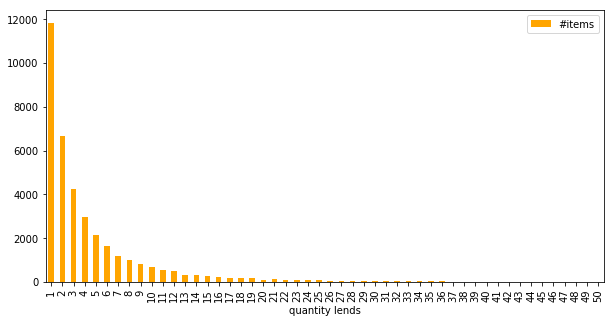

In [11]:
# 11.812 libros han sido arrendados una vez 
books_data = books_data.head(50)
books_plot = books_data.plot.bar(x='quantity lends',y='#items', color='orange', figsize=(10,5))

### usuarios que mas han arrendado: 

In [12]:
# usuario de id 3 ha arrendado 2070 libros 
user_df = grouped_books.groupby(['user']).sum()
user_df['user'] = user_df.index
user_df = user_df[['user', 'Quantity']]
user_df.sort_values(by='Quantity', ascending=False).head(5)

,user,Quantity
user,,
3,3,2070
5,5,2054
255,255,1331
13,13,1294
212,212,1111


In [13]:
users_data = user_df.groupby(['Quantity']).count()
users_data['Quantity'] = users_data.index

users_data.columns = ['#users', '#arriendos']

# hay 1210 usuarios que han arrendado tan solo un libro
users_data.head(5)

,#users,#arriendos
Quantity,,
1,1210,1
2,695,2
3,564,3
4,423,4
5,332,5


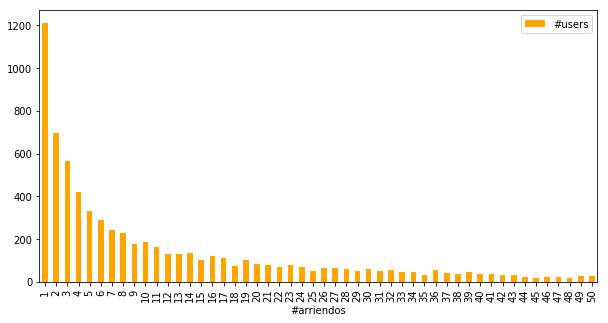

In [16]:
# hay 2274 usuarios que han arrendado una sola vez, 1352 usuarios que han arrendado 2 veces....
users_data = users_data.head(100)
users_plot = users_data.plot.bar(x='#arriendos',y='#users', color='orange', figsize=(10,5))

### Creamos matriz sparsed user - item - quantity

In [17]:
users = list(np.sort(grouped_books.user.unique())) 
books = list(grouped_books.item.unique()) 
quantity = list(grouped_books.Quantity) 
rows = grouped_books.user.astype('category', categories = users).cat.codes 
cols = grouped_books.item.astype('category', categories = books).cat.codes 
books_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(users), len(books)))
books_sparse

<7845x37267 sparse matrix of type '<class 'numpy.int64'>'
	with 164491 stored elements in Compressed Sparse Row format>

In [18]:
matrix_size = books_sparse.shape[0]*books_sparse.shape[1] 
num_book_loans = len(books_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_book_loans/matrix_size))
sparsity

99.94373675721252

In [20]:
'''recibe matriz sparsed y la divide 80/20 training y testing'''
def make_train(sparse_matrix, pct_test = 0.2):
    total_users =  7845 #users (rows de sparse matrix)
    tramo = round(total_users * (1-pct_test))
    training_set = sparse_matrix[0:tramo] 
    test_set = sparse_matrix[(tramo+1)::]
    
    return training_set, test_set  # retornamos una matriz sparse de train y de testing 

In [21]:
# split sparsed matrix
train_dataset, test_dataset = make_train(books_sparse, pct_test = 0.2)

# split dataframe 
train, test = train_test_split(grouped_books, test_size=0.2)

print(train_dataset.shape)
print(test_dataset.shape)


(6276, 37267)
(1568, 37267)


In [22]:
def get_books(user):
    return df.loc[df['user'] == user]

def get_books_test(user):
    return test.loc[test['user'] == user][['item']]
    

In [23]:
users_list = list(df['user'].unique())
items_list = list(df['item'].unique())

users_arr = np.array(users_list)
items_arr = np.array(items_list)

# libros arrendados por usuario 100 de la lista
print('libros arrendados por user_id: {}'.format(users_list[100]))
get_books(users_list[100])

libros arrendados por user_id: 12082


,user,item,title,date
205,12082,18635,Fascism /,20000512.0
1531,12082,6666,El hombre autorrealizado :,20000614.0
1822,12082,11410,El mundo de Roland Barthes /,20000621.0


In [24]:
def rec_items(user_id, mf_train, user_vecs, item_vecs, user_list, item_list, item_lookup, num_items = 10):    
    cust_ind = np.where(user_list == user_id)[0][0] # obtener el index de users id
    pref_vec = mf_train[cust_ind,:].toarray() 
    pref_vec = pref_vec.reshape(-1) + 1 # asignamos 1 a todo, asi las historias no favoriteadas tendrán valor 1. 
    pref_vec[pref_vec > 1] = 0 # reemplazamos todo lo que ya fue favorito en zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # producto punto users e items transpuesto
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # todos los items ya recomendados se multiplican por cero 
    recommend_vector = pref_vec*rec_vector_scaled 
    stories_idx = np.argsort(recommend_vector)[::-1][:num_items] # ordenamos los items y 
    # arriba quedan las mejores recomendaciones 
    rec_list = [] 
    for index in stories_idx:
        code = item_list[index]
        rec_list.append(code) 
    return rec_list # devolvemos una lista con los top 5 (num_items)

In [25]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_dataset*alpha).astype('double'), 
                                                          factors=100, 
                                                          regularization = 0.1, 
                                                         iterations = 100)

This method is deprecated. Please use the AlternatingLeastSquares class instead


In [26]:
# recomendacion implicita para el primer usuario de la lista
recommendation = rec_items(users_list[100], train_dataset, user_vecs, item_vecs, users_arr, items_arr, item_lookup,
                       num_items = 5)

In [28]:
# recomendacion para el usuario 100 de la lista 
print('libros recomendados para el usuario de id: {}'.format(users_list[100]))
df_recommended = pd.DataFrame({'item': recommendation})
df_recommended.merge(df, on='item').drop_duplicates(subset='item')[['item', 'title']]

libros recomendados para el usuario de id: 12082


,item,title
0,49337,"Fist, stick, knife, gun :"
3,7758,The leader-manager :
18,21430,La llamada de la selva /
20,21206,Sociolinguistic patterns /
46,39984,Psychologie et pédagogie /


In [29]:
users_list = list(df['user'].unique())
items_list = list(df['item'].unique())

users_arr = np.array(users_list)
items_arr = np.array(items_list)

# libros arrendados por usuario 100 de la lista
print('libros arrendados por user_id: {}'.format(users_list[100]))
get_books(users_list[100])

libros arrendados por user_id: 12082


,user,item,title,date
205,12082,18635,Fascism /,20000512.0
1531,12082,6666,El hombre autorrealizado :,20000614.0
1822,12082,11410,El mundo de Roland Barthes /,20000621.0


### Recomendacion implicit feedback: 

In [ ]:
data = []

alpha = 15 

#alpha - parametro discutido en el paper de Koren & Volinsky asociado a la matriz de confianza, 
#donde Cui = 1 + alpha*Rui. 
# Rui --> preferencia del usuario "u" por el item "i" , si Rui > 0 hay una preferencia (interaccion)
#En el paper obtienen que el default de alpha debe ser 40 (el mas efectivo) . 


user_vecs, item_vecs = implicit.alternating_least_squares((train_dataset*alpha).astype('double'), 
                                                                  factors=300, 
                                                                  regularization = 0.1, 
                                                                 iterations = 100)

# OJO al hacer el corte de train y test algunos usuarios no estan en ambos, por eso recomendamos a 10000 usuarios 
for x in users_arr[0:1500]:

    user_id = x
    
    print(user_id)
    
    # recomienda con dataset de test
    recommendation_test = rec_items(user_id, test_dataset, user_vecs, item_vecs, users_arr, items_arr, item_lookup,
                           num_items = 5)
    
    fav_stories = list(get_books_test(x)['item'])

    relevantes = []
    for x in recommendation_test:
        if x in fav_stories:
            relevantes.append(1)
        else:
            relevantes.append(0)

    ndcg5 = ndcg.ndcg(relevantes,5)
    precision5 = MAP.precision_at_k(relevantes,5)
    lista_MAP = [MAP.precision_at_k(relevantes,x) for x in range(1, len(relevantes))]
    mean_average_precision = reduce(lambda x, y: x + y, lista_MAP) / len(lista_MAP)

    #print(ndcg10)
    #print(precision10)
    #print(mean_average_precision)

    data.append(['{}'.format(user_id), ndcg5, precision5, mean_average_precision])

    df_result = pd.DataFrame(data, columns = ('user', 'ndcg@5', 'precision@5', 'MAP'))

#df_result
df_result.to_csv('implicit_results_U_ARGENTINA.csv', sep=';', index=False)

In [32]:
result = pd.read_csv('implicit_results_U_ARGENTINA.csv', sep=';')
result.describe()[['ndcg@5', 'precision@5', 'MAP']]

,ndcg@5,precision@5,MAP
count,1500.000000,1500.000000,1500.000000
mean,0.002528,0.000800,0.000917
std,0.043195,0.012628,0.019573
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,0.200000,0.520833
